# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
from collections import deque
import random
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent # Agent taken from https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py

In [9]:
hyperparams = {
    'buffer_size' : int(1e6),  # replay buffer size
    'batch_size' : 512,        # minibatch size
    'gamma' : 0.99,            # discount factor
    'tau' : 2e-1,              # for soft update of target parameters
    'lr_actor' : 1e-4,         # learning rate of the actor 
    'lr_critic' : 3e-4,        # learning rate of the critic
    'weight_decay' : 0.0000   # L2 weight decay
}

SyntaxError: invalid syntax (<ipython-input-9-2c674bb1446c>, line 3)

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, hyperparams=hyperparams)

/home/vtrudel/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


- 0.057828664779663086 seconds -
Episode 1	Average Score: 0.00
Score for this episode: [-0.01  0.  ]
- 0.08711409568786621 seconds -
Episode 2	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.06370019912719727 seconds -
Episode 3	Average Score: 0.00
Score for this episode: [-0.01  0.  ]
- 0.07026314735412598 seconds -
Episode 4	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.0912008285522461 seconds -
Episode 5	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.09231185913085938 seconds -
Episode 6	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.09814763069152832 seconds -
Episode 7	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.09149909019470215 seconds -
Episode 8	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.0717616081237793 seconds -
Episode 9	Average Score: 0.00
Score for this episode: [ 0.   -0.01]
- 0.06670093536376953 seconds -
Episode 10	Average Score: 0.00
Score for this episode: [ 0.   -0.01]


- 2.0812745094299316 seconds -
Episode 84	Average Score: 0.03
Score for this episode: [0.1  0.09]
- 0.5534772872924805 seconds -
Episode 85	Average Score: 0.03
Score for this episode: [ 0.   -0.01]
- 0.5057199001312256 seconds -
Episode 86	Average Score: 0.03
Score for this episode: [ 0.   -0.01]
- 3.4667632579803467 seconds -
Episode 87	Average Score: 0.03
Score for this episode: [0.19 0.2 ]
- 0.5501344203948975 seconds -
Episode 88	Average Score: 0.03
Score for this episode: [-0.01  0.  ]
- 0.5399906635284424 seconds -
Episode 89	Average Score: 0.03
Score for this episode: [ 0.   -0.01]
- 0.5383532047271729 seconds -
Episode 90	Average Score: 0.03
Score for this episode: [-0.01  0.  ]
- 0.5743680000305176 seconds -
Episode 91	Average Score: 0.03
Score for this episode: [ 0.   -0.01]
- 0.5390176773071289 seconds -
Episode 92	Average Score: 0.03
Score for this episode: [-0.01  0.  ]
- 3.5476579666137695 seconds -
Episode 93	Average Score: 0.03
Score for this episode: [0.2  0.19]
- 0.54

- 0.5304222106933594 seconds -
Episode 167	Average Score: 0.06
Score for this episode: [-0.01  0.  ]
- 0.5568516254425049 seconds -
Episode 168	Average Score: 0.06
Score for this episode: [-0.01  0.  ]
- 0.6566405296325684 seconds -
Episode 169	Average Score: 0.06
Score for this episode: [-0.01  0.  ]
- 1.2105228900909424 seconds -
Episode 170	Average Score: 0.06
Score for this episode: [-0.01  0.1 ]
- 0.5530052185058594 seconds -
Episode 171	Average Score: 0.06
Score for this episode: [-0.01  0.  ]
- 0.5943219661712646 seconds -
Episode 172	Average Score: 0.06
Score for this episode: [ 0.   -0.01]
- 0.5558440685272217 seconds -
Episode 173	Average Score: 0.06
Score for this episode: [ 0.   -0.01]
- 0.5569837093353271 seconds -
Episode 174	Average Score: 0.06
Score for this episode: [-0.01  0.  ]
- 0.5700278282165527 seconds -
Episode 175	Average Score: 0.06
Score for this episode: [-0.01  0.  ]
- 0.591052770614624 seconds -
Episode 176	Average Score: 0.06
Score for this episode: [-0.0

- 15.532073497772217 seconds -
Episode 249	Average Score: 0.09
Score for this episode: [1.00000001 0.99000002]
- 5.8831658363342285 seconds -
Episode 250	Average Score: 0.10
Score for this episode: [0.29       0.40000001]
- 1.1560428142547607 seconds -
Episode 251	Average Score: 0.10
Score for this episode: [ 0.1  -0.01]
- 1.2600128650665283 seconds -
Episode 252	Average Score: 0.10
Score for this episode: [ 0.1  -0.01]
- 1.1026256084442139 seconds -
Episode 253	Average Score: 0.09
Score for this episode: [ 0.   -0.01]
- 3.546342611312866 seconds -
Episode 254	Average Score: 0.09
Score for this episode: [0.19 0.2 ]
- 4.898734092712402 seconds -
Episode 255	Average Score: 0.10
Score for this episode: [0.3  0.18]
- 2.0239980220794678 seconds -
Episode 256	Average Score: 0.10
Score for this episode: [ 0.1  -0.01]
- 2.0231826305389404 seconds -
Episode 257	Average Score: 0.10
Score for this episode: [0.1  0.09]
- 4.28268575668335 seconds -
Episode 258	Average Score: 0.10
Score for this epi

- 16.598108530044556 seconds -
Episode 330	Average Score: 0.29
Score for this episode: [0.99000002 1.10000002]
- 9.062159776687622 seconds -
Episode 331	Average Score: 0.30
Score for this episode: [0.69000001 0.70000001]
- 0.4507920742034912 seconds -
Episode 332	Average Score: 0.30
Score for this episode: [ 0.   -0.01]
- 0.6951491832733154 seconds -
Episode 333	Average Score: 0.29
Score for this episode: [-0.01  0.  ]
- 4.925095796585083 seconds -
Episode 334	Average Score: 0.30
Score for this episode: [0.3  0.19]
- 1.2053117752075195 seconds -
Episode 335	Average Score: 0.30
Score for this episode: [ 0.1  -0.01]
- 22.008038759231567 seconds -
Episode 336	Average Score: 0.31
Score for this episode: [1.39000002 1.40000002]
- 1.1795258522033691 seconds -
Episode 337	Average Score: 0.31
Score for this episode: [ 0.1  -0.01]
- 15.88321042060852 seconds -
Episode 338	Average Score: 0.32
Score for this episode: [1.00000001 0.99000002]
- 1.2206690311431885 seconds -
Episode 339	Average Score

- 41.883254051208496 seconds -
Episode 408	Average Score: 0.90
Score for this episode: [2.60000004 2.60000004]
- 2.611849784851074 seconds -
Episode 409	Average Score: 0.90
Score for this episode: [0.09 0.2 ]
- 1.3403644561767578 seconds -
Episode 410	Average Score: 0.90
Score for this episode: [-0.01  0.1 ]
- 3.7018980979919434 seconds -
Episode 411	Average Score: 0.90
Score for this episode: [0.19 0.2 ]
- 0.5791301727294922 seconds -
Episode 412	Average Score: 0.87
Score for this episode: [ 0.   -0.01]
- 2.1763107776641846 seconds -
Episode 413	Average Score: 0.88
Score for this episode: [-0.01  0.1 ]
- 1.2638795375823975 seconds -
Episode 414	Average Score: 0.88
Score for this episode: [-0.01  0.1 ]
- 2.141655921936035 seconds -
Episode 415	Average Score: 0.88
Score for this episode: [0.1  0.09]
- 5.028071641921997 seconds -
Episode 416	Average Score: 0.88
Score for this episode: [0.3  0.19]
- 19.640576601028442 seconds -
Episode 417	Average Score: 0.89
Score for this episode: [1.09

- 1.2834663391113281 seconds -
Episode 486	Average Score: 0.92
Score for this episode: [0.   0.09]
- 43.55242705345154 seconds -
Episode 487	Average Score: 0.92
Score for this episode: [2.60000004 2.60000004]
- 17.954936504364014 seconds -
Episode 488	Average Score: 0.93
Score for this episode: [0.99000002 1.10000002]
- 14.90114688873291 seconds -
Episode 489	Average Score: 0.94
Score for this episode: [0.90000001 0.79000001]
- 38.70841860771179 seconds -
Episode 490	Average Score: 0.94
Score for this episode: [2.19000003 2.30000003]
- 43.78129506111145 seconds -
Episode 491	Average Score: 0.96
Score for this episode: [2.50000004 2.60000004]
- 4.100086450576782 seconds -
Episode 492	Average Score: 0.94
Score for this episode: [0.3  0.19]
- 5.550135374069214 seconds -
Episode 493	Average Score: 0.92
Score for this episode: [0.3  0.29]
- 7.167067527770996 seconds -
Episode 494	Average Score: 0.91
Score for this episode: [0.40000001 0.39000001]
- 5.25163459777832 seconds -
Episode 495	Ave

- 5.718930959701538 seconds -
Episode 563	Average Score: 1.28
Score for this episode: [0.3  0.19]
- 4.076732158660889 seconds -
Episode 564	Average Score: 1.28
Score for this episode: [0.19 0.2 ]
- 46.92405319213867 seconds -
Episode 565	Average Score: 1.30
Score for this episode: [2.60000004 2.60000004]
- 46.996347427368164 seconds -
Episode 566	Average Score: 1.32
Score for this episode: [2.70000004 2.60000004]
- 46.78859233856201 seconds -
Episode 567	Average Score: 1.34
Score for this episode: [2.60000004 2.60000004]
- 47.290977239608765 seconds -
Episode 568	Average Score: 1.36
Score for this episode: [2.60000004 2.70000004]
- 47.042840242385864 seconds -
Episode 569	Average Score: 1.38
Score for this episode: [2.60000004 2.60000004]
- 47.546630859375 seconds -
Episode 570	Average Score: 1.38
Score for this episode: [2.70000004 2.60000004]
- 4.7127673625946045 seconds -
Episode 571	Average Score: 1.38
Score for this episode: [0.2  0.19]
- 47.5957465171814 seconds -
Episode 572	Ave

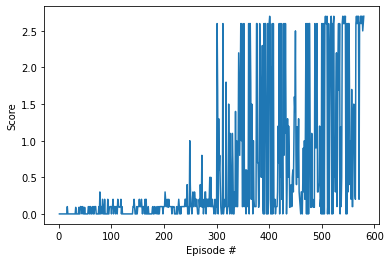

In [9]:
def maddpg(n_episodes=100000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_history = []
    for i_episode in range(1, n_episodes+1):
        start_time = time.time()
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment  
        agent.reset()
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = [agent.act(s, add_noise=False) for s in states]
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            for n in range(num_agents):
                agent.step(states[n], actions[n], rewards[n], next_states[n], dones[n]) 
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        scores_deque.append(np.max(scores))
        scores_history.append(np.max(scores))
        print("- %s seconds -" % (time.time() - start_time))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        print('Score for this episode: {}'.format(scores))
    
        if np.mean(scores_deque) > 1.5:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rSOLVED!!  Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
        
    return scores_history

scores = maddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [21]:


agents = [Agent(state_size=state_size, action_size=action_size, hyperparams=hyperparams) for n in range(num_agents)]
for n in range(num_agents):
    agents[n].actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
    agents[n].critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [22]:

env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = [agents[n].act(states[n], add_noise=False) for n in range(num_agents)]
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    for n in range(num_agents):
        agents[n].step(states[n], actions[n], rewards[n], next_states[n], dones[n]) 
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 1.7950000269338489
